In [0]:
#Block 1 server setup 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.4-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
#Block 2 sync colabserver with drive
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
!ls drive/'Face Recognition'/From_git
!ls

A.jpg			 gen_emb.py			  README.md
CoreML-Convertion.ipynb  gen_emb.pyc			  Untitled.ipynb
evaluation		 Keras-Openface-Accuracy.ipynb	  utils.lua
exportWeight.lua	 Keras-openface-convertion.ipynb  utils.py
facenet.py		 lfw.py				  utils.pyc
facenet.pyc		 lfw.pyc			  weights
Face_recog.ipynb	 model
adc.json  drive  sample_data


In [0]:
import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D


_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
  v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
  _get_session().run(v.initializer)
  return v

def shape(x):
  return x.get_shape()

def square(x):
  return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
  return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
  if axis < 0:
      axis = axis % len(tensors[0].get_shape())
  return tf.concat(axis, tensors)

def LRN2D(x):
  return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
  num = '' if cv2_out == None else '1'
  tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
  tensor = Activation('relu')(tensor)
  if padding == None:
    return tensor
  tensor = ZeroPadding2D(padding=padding)(tensor)
  if cv2_out == None:
    return tensor
  tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
  tensor = Activation('relu')(tensor)
  return tensor

weights = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights():
  # Set weights path
  dirPath = 'drive/Face Recognition/From_git/weights'
  fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
  paths = {}
  weights_dict = {}

  for n in fileNames:
    paths[n.replace('.csv', '')] = dirPath + '/' + n

  for name in weights:
    if 'conv' in name:
      conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      conv_w = np.reshape(conv_w, conv_shape[name])
      conv_w = np.transpose(conv_w, (2, 3, 1, 0))
      conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      weights_dict[name] = [conv_w, conv_b]     
    elif 'bn' in name:
      bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
      bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
      weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
    elif 'dense' in name:
      dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
      dense_w = np.reshape(dense_w, (128, 736))
      dense_w = np.transpose(dense_w, (1, 0))
      dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
      weights_dict[name] = [dense_w, dense_b]

  return weights_dict

Using TensorFlow backend.


In [0]:

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K

#import utils
#from utils import LRN2D

def create_model():
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)

In [0]:

nn4_small2 = create_model()
nn4_small2_weights = load_weights()

In [0]:
for name, w in nn4_small2_weights.items():
    if nn4_small2.get_layer(name) != None:
        nn4_small2.get_layer(name).set_weights(w)

nn4_small2.save_weights('drive/Face Recognition/From_git/weights/nn4.small2.v1.h5')

In [0]:
from keras.models import load_model
#nn4_small2.save('drive/Face Recognition/From_git/weights/face_recognizer.h5')
#model = load_model('drive/Face Recognition/From_git/weights/face_recognizer.h5')
new_model = load_model('drive/Face Recognition/From_git/weights/face_recognizer.h5', custom_objects = { "tf": tf })

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_96 (ZeroPadding2 (None, 102, 102, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_96[0][0]          
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

(96, 96, 3)


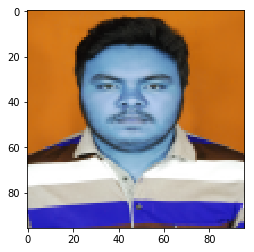

In [0]:
import cv2
from matplotlib import pyplot as plt
dim = (96,96)
img = cv2.imread("drive/Face Recognition/From_git/A.jpg")
img = cv2.resize(img,dim, interpolation = cv2.INTER_AREA)
print(img.shape)

plt.imshow(img)
plt.show()

In [0]:
print(new_model.predict(np.array([img])))
new = np.array([img])
print(new.shape)
def give(path):
  dim = (96,96)
  img = cv2.imread(path)
  img = cv2.resize(img,dim, interpolation = cv2.INTER_AREA)
  y = new_model.predict(np.array([img]))
  return y

[[-0.04217995  0.14944345 -0.10404313 -0.00663027  0.01908418  0.13084783
  -0.01963184 -0.02456114 -0.04494078  0.06173051  0.04069598  0.00598532
   0.09716475  0.01019873  0.00967334  0.0404051   0.03280722 -0.0258471
  -0.04030657  0.12975742  0.01807572 -0.16706476  0.07651704  0.12354409
  -0.02047358 -0.05328545 -0.09142009 -0.08366004  0.05839644  0.01612702
   0.09955457  0.11213022  0.0289701   0.05375334 -0.09799892  0.17004271
   0.02861685  0.11729716 -0.067876    0.0118828   0.01115484 -0.05745906
   0.01349246 -0.07134548 -0.0451975  -0.00673442  0.1795917   0.03632157
  -0.13662261  0.049623   -0.07650196 -0.01798544 -0.04599587 -0.00490743
   0.09282771  0.10530993 -0.049362    0.12173747  0.00202254 -0.08493068
  -0.18045095  0.07755082  0.14493392 -0.28632054  0.08576105  0.1219589
   0.01367609  0.02487385 -0.17744029  0.05341637 -0.03067566  0.07239956
  -0.11732591  0.10741872  0.15024978  0.02530786  0.07028842  0.09768862
   0.02333609 -0.08547982 -0.13052845  0

In [0]:
y1 = give("drive/Face Recognition/From_git/A.jpg")
y2 = give("drive/Face Recognition/From_git/A1.jpg")
y3 = give("drive/Face Recognition/From_git/Ba.jpg")
print(np.linalg.norm(y1-y2))
print(np.linalg.norm(y2-y3))

0.41318598
0.48685288


In [0]:
face_cascade = cv2.CascadeClassifier("drive/Face Recognition/From_git/haarcascade_frontalface_default.xml")
img = cv2.imread("drive/Face Recognition/From_git/Ba.jpg")
print(img.shape)
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(len(face))
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
plt.imshow(img)
plt.show()

In [0]:
path = "drive/Face Recognition/From_git/Ba.jpg"
dim = (96,96)
img = cv2.imread(path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
(x,y,w,h) = faces[0]
crop_img = img[y:y+h, x:x+w]
img = cv2.resize(crop_img,dim, interpolation = cv2.INTER_AREA)
#y = new_model.predict(np.array([img]))
#print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
from scipy.spatial import distance
def give2(path):
  dim = (96,96)
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  (x,y,w,h) = faces[0]
  crop_img = img[y:y+h, x:x+w]
  img = cv2.resize(crop_img,dim, interpolation = cv2.INTER_AREA)
  y = new_model.predict(np.array([img]))
  #plt.imshow(img)
  #plt.show()
  return y[0]
y1 = give2("drive/Face Recognition/From_git/A.jpg")
y2 = give2("drive/Face Recognition/From_git/A1.jpg")
y3 = give2("drive/Face Recognition/From_git/Brad.jpg")
#print(np.linalg.norm(np.abs(y1-y2)))
#print(np.linalg.norm(np.abs(y1-y3)))
print(distance.euclidean(y1, y2))
print(distance.euclidean(y1, y3))

[0.38210344]
[0.19228017]
0.38210344314575195
0.19228017330169678


In [0]:
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
from keras.models import load_model
import cv2
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
#import utils as K

#np.set_printoptions(threshold=np.nan)

path1='/Users/victor_sy_wang/Developer/ML/openface/images/examples-aligned/lennon-1.png'
path2='drive/Face Recognition/From_git/A.jpg'
path3='/Users/victor_sy_wang/Developer/ML/keras-facenet/data/dlib-affine-sz/Abel_Pacheco/Abel_Pacheco_0001.png'

img = cv2.imread(path2, 1)
img = img[...,::-1]
img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)

model = load_model('drive/Face Recognition/From_git/model/nn4.small2.v1.h5')

x_train = np.array([img])
y = model.predict_on_batch(x_train)

print(y)

In [0]:
# Copyright 2015-2016 Carnegie Mellon University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Module for dlib-based alignment."""

import cv2
import dlib
import numpy as np

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)


class AlignDlib:
    """
    Use `dlib's landmark estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_ to align faces.
    The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.
    Normalized landmarks:
    .. image:: ../images/dlib-landmark-mean.png
    """

    #: Landmark indices.
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
    OUTER_EYES_AND_NOSE = [36, 45, 33]

    def __init__(self, facePredictor):
        """
        Instantiate an 'AlignDlib' object.
        :param facePredictor: The path to dlib's
        :type facePredictor: str
        """
        assert facePredictor is not None

        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(facePredictor)

    def getAllFaceBoundingBoxes(self, rgbImg):
        """
        Find all face bounding boxes in an image.
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :return: All face bounding boxes in an image.
        :rtype: dlib.rectangles
        """
        assert rgbImg is not None

        try:
            return self.detector(rgbImg, 1)
        except Exception as e:
            print("Warning: {}".format(e))
            # In rare cases, exceptions are thrown.
            return []

    def getLargestFaceBoundingBox(self, rgbImg, skipMulti=False):
        """
        Find the largest face bounding box in an image.
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The largest face bounding box in an image, or None.
        :rtype: dlib.rectangle
        """
        assert rgbImg is not None

        faces = self.getAllFaceBoundingBoxes(rgbImg)
        if (not skipMulti and len(faces) > 0) or len(faces) == 1:
            return max(faces, key=lambda rect: rect.width() * rect.height())
        else:
            return None

    def findLandmarks(self, rgbImg, bb):
        """
        Find the landmarks of a face.
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to find landmarks for.
        :type bb: dlib.rectangle
        :return: Detected landmark locations.
        :rtype: list of (x,y) tuples
        """
        assert rgbImg is not None
        assert bb is not None

        points = self.predictor(rgbImg, bb)
        return list(map(lambda p: (p.x, p.y), points.parts()))

    def align(self, imgDim, rgbImg, bb=None,
              landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP,
              skipMulti=False):
        r"""align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)
        Transform and align a face in an image.
        :param imgDim: The edge length in pixels of the square the image is resized to.
        :type imgDim: int
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to align. \
                   Defaults to the largest face.
        :type bb: dlib.rectangle
        :param landmarks: Detected landmark locations. \
                          Landmarks found on `bb` if not provided.
        :type landmarks: list of (x,y) tuples
        :param landmarkIndices: The indices to transform to.
        :type landmarkIndices: list of ints
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
        :rtype: numpy.ndarray
        """
        assert imgDim is not None
        assert rgbImg is not None
        assert landmarkIndices is not None

        if bb is None:
            bb = self.getLargestFaceBoundingBox(rgbImg, skipMulti)
            if bb is None:
                return

        if landmarks is None:
            landmarks = self.findLandmarks(rgbImg, bb)

        npLandmarks = np.float32(landmarks)
        npLandmarkIndices = np.array(landmarkIndices)

        H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                                   imgDim * MINMAX_TEMPLATE[npLandmarkIndices])
        thumbnail = cv2.warpAffine(rgbImg, H, (imgDim, imgDim))

        return thumbnail

In [90]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]
def align_image(img):
  alignment = AlignDlib('drive/Face Recognition/From_git/model/landmarks.dat')
  return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
embedded = []
image_filenames = filter(lambda x: x.endswith('.jpg'), os.listdir("drive/Face Recognition/Vai's FR/images/"))
image_filenames = sorted(image_filenames)
names = [x[:-4] for x in image_filenames]
print(names)
paths_to_images = ["drive/Face Recognition/Vai's FR/images/" + x for x in image_filenames]

for path_to_image in paths_to_images:
    img = load_image(path_to_image)
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded.append(new_model.predict(np.expand_dims(img, axis=0))[0])
print(len(embedded))

['obama', 'pantho']
2


In [91]:
#from scipy.spatial import distance
def give3(path):
  img = load_image(path)
  img = align_image(img)
  img = (img / 255.).astype(np.float32)
  y = new_model.predict(np.expand_dims(img, axis=0))[0]
  #print(type(y))
  return y
  
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))
y1 = give3("drive/Face Recognition/From_git/A.jpg")
y2 = give3("drive/Face Recognition/From_git/A1.jpg")
y3 = give3("drive/Face Recognition/From_git/Brad.jpg")
#print(np.linalg.norm(np.abs(y1-y2)))
#print(np.linalg.norm(np.abs(y1-y3)))
#print(y1)
print(distance(y1, y2))
print(distance(y2, y3))
print(distance(y1, y3))

0.2188293
1.8662906
2.0639548


In [107]:
TOLERANCE = 0.5

test_filenames = filter(lambda x: x.endswith('.jpg'), os.listdir("drive/Face Recognition/Vai's FR/test/"))
paths_to_test_images = ["drive/Face Recognition/Vai's FR/test/" + x for x in test_filenames]
#print(paths_to_test_images)
for path_to_test in paths_to_test_images:
  encoded = give3(path_to_test)
  ct = 0
  for path_to_image in paths_to_images:
    encoded2 = give3(path_to_image)
    ct+=1
    if(distance(encoded,encoded2)<=TOLERANCE):
      print(path_to_test, " ", names[ct-1])
      break
    elif(ct == len(paths_to_images)):
      print(path_to_test, " ","Not Found")
    

drive/Face Recognition/Vai's FR/test/elon.jpg   Not Found
drive/Face Recognition/Vai's FR/test/o.jpg   obama
drive/Face Recognition/Vai's FR/test/A1.jpg   pantho
